In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder

from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit

In [2]:
folder_dir = '../data/'
data_path = "data_clean.csv"
data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
data=data.drop('Unnamed: 0',axis=1)

#=data.head(500)

In [3]:
data.shape

(3902210, 22)

In [4]:
data.isnull().any()[data.isnull().any()]

outcome    True
nasty      True
pitcher    True
dtype: bool

## Target feature

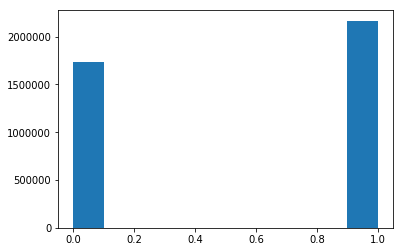

In [5]:
#Using descr feature to define good pitch
g_outcomes=['Foul Tip','Swinging Strike','In play, out(s)', 'Called Strike', 'Foul','Foul (Runner Going)','Foul Bunt',
       'Swinging Strike (Blocked)', 'Missed Bunt' ]

#Using outcome feature to use more detailed descriptions (eg: lineout vs groundout). I think this approach is better
g_outcomes2=['Flyout', 'Fly Out','Groundout','Pop Out','Forceout','Double Play','Grounded into DP','Fielders Choice',
             'Fielders Choice Out','Bunt Groundout','Bunt Pop Out','Sac Fly DP','Bunt Lineout','Foul']

data['y']=np.where((data['outcome'].isin(g_outcomes2)) | (data['umpcall']=='S'),1,0)
a=plt.hist(data['y'])

### Generate batter-pitcher count
##### https://twitter.com/darenw/status/985168614008508416 (cool image)

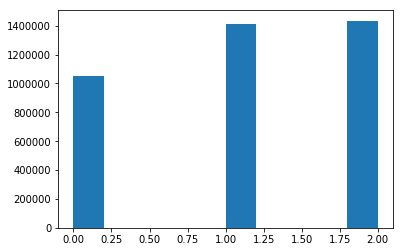

In [6]:
data['count_b_p']=np.where((data['strikes']>data['balls']),2,0)

data['count_b_p']=np.where(((data['strikes']==0) & (data['balls']==0)),1,data['count_b_p'])
data['count_b_p']=np.where(((data['strikes']==1) & (data['balls']==1)),1,data['count_b_p'])

# 2-2 is a pitchers' count
data['count_b_p']=np.where(((data['strikes']==2) & (data['balls']==2)),2,data['count_b_p'])
plt.hist(data.count_b_p);

### One-hot encode zone

In [7]:
data['zone'].unique()

array([ 9,  4, 11, 13,  6, 14,  5,  1,  2, 12,  7,  8,  3], dtype=int64)

In [8]:
zone=pd.get_dummies(data['zone'],prefix='zone').drop('zone_14',axis=1)
data=pd.concat([data,zone],axis=1).drop('zone',axis=1)

In [9]:
### Create features
data.columns

Index(['umpcall', 'outcome', 'start_speed', 'pfx_x', 'pfx_z', 'px', 'pz',
       'break_y', 'break_angle', 'break_length', 'pitch_type', 'spin_dir',
       'nasty', 'pitch_count', 'descr', 'y', 'year', 'strikes', 'balls',
       'pitcher', 'pitch_type.1', 'count_b_p', 'zone_1', 'zone_2', 'zone_3',
       'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11',
       'zone_12', 'zone_13'],
      dtype='object')

## Train, test, validation split

In [10]:
model_feats=['px','pz','pfx_x','pfx_z','start_speed','spin_dir','pitch_count','count_b_p']
y=data['y']
data=data[model_feats]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=1)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [12]:
#train_index=[-1]*(X_train.shape[0])
#val_index=[0]*(X_val.shape[0])
#ps=PredefinedSplit(test_fold=np.concatenate((train_index,val_index)))

## Logistic Regression

In [ ]:
#Create pipeline
steps= [('polyfeat', PolynomialFeatures()),
         ('scaler', StandardScaler()),
         ('lr', LogisticRegression())]

mypipeline= Pipeline(steps)
parameters = dict(lr__C = [10**i for i in range(-2, 2)],
                  lr__penalty = ['l1', 'l2'])

In [ ]:
lr_grid_search= GridSearchCV(mypipeline, 
                             param_grid = parameters,  
                             scoring = 'log_loss',
                             n_jobs=2, 
                             refit=True)

lr_grid_search.fit(X_train, y_train)

In [ ]:
best_1 = lr_grid_search.best_score_
print(best_1)
lr_grid_search.best_estimator_
model=lr_grid_search.best_estimator_.steps[2][1]
print(model)

In [ ]:
model=lr_grid_search.best_estimator_.steps[2][1]

In [ ]:
coef_dict = {}
for coef, feat in zip(model.coef_[0],X_train.columns.tolist()):
    coef_dict[feat] = coef
coef_dict

In [ ]:
STOP=

### RANDOM FOREST

In [ ]:
steps= [('polyfeat', PolynomialFeatures()), ('scaler', StandardScaler()),('rf', RandomForestClassifier())]

steps= [('rf', RandomForestClassifier())]

mypipeline= Pipeline(steps)

param_grid_rf = dict(
    #rf__min_samples_leaf= np.logspace(4, 5, num=5, base=4, endpoint=False, dtype=int),
    rf__min_samples_split= [100, 1000],
    rf__max_depth= list(range(4,9,2)),
    rf__n_estimators= list(range(200,500,100))
      )

In [ ]:
rf_grid_search= GridSearchCV(mypipeline, 
                             param_grid = param_grid_rf, 
                             scoring = 'log_loss',
                                    n_jobs=-1, refit=True)

rf_grid_search.fit(X_train, y_train)

In [ ]:
best_1 = rf_grid_search.best_score_
print(best_1)
rf_grid_search.best_estimator_
model=rf_grid_search.best_estimator_.steps[2][1]
print(model)

In [ ]:
model=rf_grid_search.best_estimator_.steps[2][1]

In [ ]:
# RF Feature Importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig = plt.figure(figsize=(20,8))
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.title('Feature Importances Bar Plot')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.xticks(range(len(indices)), train_val.drop('Y', axis=1).columns[indices], rotation=45, horizontalalignment='right')
plt.xlim([-1, len(indices)])
plt.title('Feature Importance Graph for RF')
plt.show()
print('\rSaving feature_importances barplot... ', end='')
fig.savefig(rf_dir + 'feature_importances_rf.png')
print('done.')